In [120]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import random
from functools import reduce

In [121]:
src,img, img_name, max_row, max_col,channel = None,None,None,None,None,None

In [122]:
def euclidean(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Three Points Circle Fitting

In [123]:
#Perpendicular Bisector Method
def three_point_circle(p1,p2,p3):
    global max_row, max_col
    m1 = math.inf if p1[0] == p2[0] else (p1[1]-p2[1])/(p1[0]-p2[0])
    m2 = math.inf if p1[0] == p3[0] else (p1[1]-p3[1])/(p1[0]-p3[0])
    if m1 == m2: #Colinear
        return None
    mid1 = list(map(lambda a1,a2:a1+(a2-a1)/2,p1,p2))
    mid2 = list(map(lambda a1,a2:a1+(a2-a1)/2,p1,p3))
    mper1 = math.inf if m1 == 0 else 1/m1
    mper2 = math.inf if m2 == 0 else 1/m2
    b1 = None if mper1 == math.inf else mid1[1] - mper1*mid1[0]
    b2 = None if mper2 == math.inf else mid2[1] - mper2*mid2[0]
    
    #Circle: center(x,y), radius(r)
    if b1 and b2: #Both line not verticle
        x = (b2-b1) / (mper1-mper2) * mper1 + b1
        y = mper1 * x + b1    
    else: #One line verticle(x = contant)
        x = mid2[0] if b1 else mid1[0]
        y = mper1 * mid2[0] + b1 if b1 else mper2 * mid1[0] + b2
    r = euclidean(p1,(x,y))
    if x < 0 or y < 0 or x > max_row or y > max_col:
        return None #Discard any circle that center is not in the image
    return int(x),int(y),int(r)

# RANSAC and Post Processing

In [124]:
def ransac(edges):
    global src,img,max_row,max_col
    i,c, circle = 0, -1, [0,0,0]
    e = set(edges) #edge points from canny edge detector
    e1 = 6 # inliers critia 1: thickness of the circle is 6
    countMiss = 0
    while i < 20000:
        ps = random.sample(range(len(edges)),3) # 3 random points in edge points
        result = three_point_circle(edges[ps[0]],edges[ps[1]],edges[ps[2]]) # Get center and radius
        if not result:
            countMiss += 1
            continue
        x,y,r = result
        blank = np.zeros(img.shape, dtype = np.uint8) 
        circleimg = cv2.circle(blank,(y,x),r,e1) #Generate the circle on a blank image with thickness e1
        newedges = np.where(circleimg != [0]) # Get circle points
        newedges = list(zip(newedges[0],newedges[1])) # Get circle point positions
        inliers = list(filter(lambda a:a in e,newedges)) # inliers = overlap points of edges and the circle 
        circle = [x,y,r]  if c < len(inliers) else circle
        c = len(inliers) if c < len(inliers) else c # get max number of inliers
        #if newedges and len(inliers)/len(newedges) > 0.9:
            #break
        if i%200 == 0:
            print('.',end=' ')
        i += 1
    print('\n')
    print(f"The number of iterations: {i}")
    print(f"Before post processing: center=({circle[0]},{circle[1]}), radius = {circle[2]}")
    
    ###################
    # Post Processing #
    ###################
    e2 = 3 # inliers critia 2: thickness of the circle is 3
    blank = np.zeros(img.shape, dtype = np.uint8)
    circleimg = cv2.circle(blank,(circle[1],circle[0]),circle[2],[255,255,255],e2)
    newedges = np.where(circleimg != [0])
    newedges = list(zip(newedges[0],newedges[1]))
    inliers2 = list(filter(lambda a:a in e,newedges)) # New inliers positions
    
    centroid = tuple(map(lambda a:int(a/len(inliers2)),map(sum, zip(*inliers2))))
    r2 = int(reduce(lambda a,b: a+b,map(lambda a:euclidean(a,centroid),inliers2))/len(inliers2))
    print(f"After post processing: center=({centroid[0]},{centroid[1]}), radius = {r2}")
    print("Totall ignore point = ",countMiss)
    
    plt.subplot(1,3,1)
    plt.title("Edge Image")
    plt.imshow(img,cmap = 'gray')
    
    img1 = cv2.circle(src.copy(),(circle[1],circle[0]),circle[2],(255,0,0),4)
    plt.subplot(1,3,2)
    plt.title("Before processing")
    plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
    
    img2 = cv2.circle(src.copy(),(centroid[1],centroid[0]),r2,(0,0,255),4)
    plt.subplot(1,3,3)
    plt.title("After processing")
    plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

In [125]:
def run(s):
    global src,img, img_name, max_row, max_col,channel
    img_name = s
    src = cv2.imread(img_name).copy()
    img = cv2.imread(img_name).copy()
    max_row, max_col, channel = img.shape
    img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
    img = cv2.Canny(img,150,500)
    edges = np.where(img != [0])
    edges = list(zip(edges[0],edges[1])) # edge pixel positions
    ransac(edges)

In [126]:
# run('circle.jpg')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

The number of iterations: 20000
Before post processing: center=(152,150), radius = 104
After post processing: center=(151,149), radius = 103
Totall ignore point =  8531


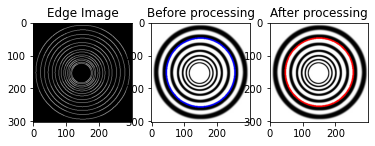

In [127]:
run("concentric_circles.jpg")

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

The number of iterations: 20000
Before post processing: center=(99,145), radius = 49
After post processing: center=(72,147), radius = 38
Totall ignore point =  16868


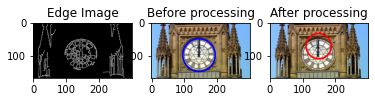

In [128]:
run("parliament_clock.jpg")